In [1]:
''' This notebook is better run on a GPU '''
''' Imports and such '''
''' The essentials '''
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

''' Base stuff '''
import os
import re

''' Gensim Stuff '''
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora 
from gensim.models.ldamulticore import LdaMulticore
#from gensim.models import LdaMulticore
from gensim.corpora import Dictionary
import pyLDAvis.gensim

''' Vectorizers '''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from nltk.stem import SnowballStemmer

''' Pipeline '''
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier, SGDRegressor 

''' Ensemble Stuff '''
from sklearn.ensemble import RandomForestClassifier

''' KNN '''
from sklearn.neighbors import NearestNeighbors

''' PreProcessing '''
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

''' TensorFlow Stuff '''
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Conv1D, MaxPooling1D, Activation
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical, get_file
from tensorflow.keras.preprocessing import sequence #one_hot, hashing_trick
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict
/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/google/protobuf/descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from google.protobuf.pyext import _message


In [2]:
''' Ringing in the Data '''

reviews_df = pd.read_csv('yelp_review.csv', engine='python', error_bad_lines=False)
business_df = pd.read_csv('yelp_business.csv')
#tips_df = pd.read_csv('yelp_tip.csv', engine='python', error_bad_lines=False)
#attributes_df = pd.read_csv('yelp_business_attributes.csv')

print(reviews_df.shape) #, business_df.shape, tips_df.shape, attributes_df.shape)
''' Jesus, dem shape sizes '''
reviews_df = reviews_df.drop(columns = {'review_id', 'date', 'useful', 'funny', 'cool'})
business_df = business_df.drop(columns = {'neighborhood', 'address', 'postal_code', 'latitude', 'longitude', 'is_open', 'categories', 'city', 'state', 'review_count'})
business_df = business_df.rename(columns={'stars' : 'rating'})

(5261668, 9)


In [3]:
print(reviews_df.shape)
reviews_df.head()

(5261668, 4)


,user_id,business_id,stars,text
0,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,Super simple place but amazing nonetheless. It...
1,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,Small unassuming place that changes their menu...
2,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,Lester's is located in a beautiful neighborhoo...
3,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,Love coming here. Yes the place always needs t...
4,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,Had their chocolate almond croissant and it wa...


In [4]:
''' Merging the DataFrames '''
reviews_df = pd.merge(reviews_df, business_df, how='inner')

In [5]:
print(reviews_df.shape)
reviews_df.head()

(5261668, 6)


,user_id,business_id,stars,text,name,rating
0,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,Super simple place but amazing nonetheless. It...,"""Wilensky's""",4.0
1,xYciRtVZ1PW4IxSX4oJ1aw,AEx2SYEUJmTxVVB18LlCwA,5,*The shop was featured on Mind of a Chef with ...,"""Wilensky's""",4.0
2,5Ymfsf9fAYz-Ds_p0xawVQ,AEx2SYEUJmTxVVB18LlCwA,5,"As its name suggests, Wilensky's is a lunch co...","""Wilensky's""",4.0
3,DVOOF0Z627DyrZ4XKQbTgA,AEx2SYEUJmTxVVB18LlCwA,5,"Stopped by for the Wilensky's Special, loved i...","""Wilensky's""",4.0
4,5JoKz3mU42Cp906KRXDwJw,AEx2SYEUJmTxVVB18LlCwA,4,"I have to admit, I am a fan. Just entering the...","""Wilensky's""",4.0


In [6]:
''' Getting only the Taco places  '''

mask = (reviews_df['text'].str.contains('taco'))
reviews_df = reviews_df[mask]
tacos_df = reviews_df

In [7]:
print(reviews_df.shape)
''' 
Of those 5 million reviews(lol) roughly 122k deal with places that serve 
tacos, so we'll start from there
'''

(121979, 6)


" \nOf those 5 million reviews(lol) roughly 122k deal with places that serve \ntacos, so we'll start from there\n"

In [8]:
''' 
Taking smaples of the data so that it's easier to work with, when final 
model is complete, will comment out this section and run the full notebook
'''
reviews_df, X_test = train_test_split(reviews_df, train_size = .92, random_state=69)

In [9]:
print(reviews_df.shape)
''' Niceeeee we can work with this  '''

(112220, 6)


' Niceeeee we can work with this  '

In [10]:
''' Cleaning up the text and preparing for NLP '''
STOPWORDS = set(STOPWORDS).union(set(['the', 'aa', 'aaa', 'aaaaaa' ])) # will update as I go further along


def tokenize(text): 
    return [token for token in simple_preprocess(text) if token not in STOPWORDS and len(token) >=3]

''' Also throwing in some regex cleaning just for good measure '''
def clean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.replace('\n', '')
    
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

In [11]:
reviews_df['tokens'] = reviews_df['text'].apply(tokenize, clean)
X_test['tokens'] = X_test['text'].apply(tokenize, clean)
tacos_df['tokens'] = tacos_df['text'].apply(tokenize, clean)
reviews_df['tokens'].head()

/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


423810     [cosmo, best, restaurants, strip, excited, try...
1101674    [ate, lunch, juan, server, tostada, salad, sho...
2314731    [team, came, work, dinner, drinks, week, open,...
87975      [location, lovely, atmosphere, delightful, ser...
1066501    [stopped, visiting, rock, roll, hall, fame, wi...
Name: tokens, dtype: object

In [12]:
''' Vectorizing the text column '''
vect = TfidfVectorizer()
text = X_test['tokens'].astype(str)
vect.fit(text)
dtm = vect.transform(text)

In [13]:
reviews_df['tokens']

423810     [cosmo, best, restaurants, strip, excited, try...
1101674    [ate, lunch, juan, server, tostada, salad, sho...
2314731    [team, came, work, dinner, drinks, week, open,...
87975      [location, lovely, atmosphere, delightful, ser...
1066501    [stopped, visiting, rock, roll, hall, fame, wi...
                                 ...                        
1431524    [enjoy, going, carolina, area, definitely, ste...
722865     [great, little, taco, spot, hidden, phoenix, p...
320038     [visited, bustling, friday, night, hostess, ta...
2147472    [couple, times, enjoy, andrew, server, night, ...
2012844    [love, restaurants, converted, houses, ask, pa...
Name: tokens, Length: 112220, dtype: object

In [14]:
# Checking out Feature names
feature_names = vect.get_feature_names()
#print(feature_names)

In [15]:
''' Converting spare matrix and putting it into a dataframe and using get_feature_names as the column headers '''
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.head()



,aaaaaamazing,aaaaand,aaaand,aaah,aaannd,aah,aahhh,aand,aaron,aback,...,étaient,étais,était,étant,étroitesse,été,évidemment,être,ímuy,über
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
''' Doing KNN on a Fake review I make and finding the nearest 10 Neighbors '''
nn  = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [17]:
fake_ass_review = ['''
Came here for Lunch with my great great great anny who aboslutely LOVES tacos along with her taco nacho monster plate.
We actually hail from Los Angeles where the tacos are fresh so the tacos here in Vegas was alright but it could have 
been better. I personally claim myself as being a true honest to goodness taco Afficienado so when I first laid 
eyes on the tacos here i was pretty blown away by the presentation however once I actually started to dig in it became 
very apparent that it would NOT be living up to how good it's presentation was. 

Oh well, any day where you get to eat tacos is a good day in my book. 
Espeically when you get to eat tacos with you great great great GREAT anny. 

OH and the prices are higher than cheech and chong on a Joe rogan Podcast with Elon Musk.

''']

In [18]:
new = vect.transform(fake_ass_review)
a = nn.kneighbors(new.todense())

In [19]:
a[0:2]

(array([[1.23945952, 1.24225552, 1.26149741, 1.26359526, 1.2689409 ]]),
 array([[5313, 5492, 1633, 9327, 3766]]))

In [20]:
print(reviews_df['text'].iloc[5313])

''' 
ahahha nice, so the recommendations thing works and finds the nearest review,
totally not neccessary for this project but could be fun stretch goal if we have time 
to spare. The usefulness here is that if someone had a text review just like YOURS for 
another taco place, it's likely that those two people are very similar and thus could 
serve as a good potential place for that other person to try out. Kinda like how spotify
does their song recommendations. Just we need to SQL Business ID and Business name and 
boom, theres a list of recommendations. 
'''

The chips were kinda stale, but the tacos were yummy!   I would for sure give this another try if in the area!


" \nahahha nice, so the recommendations thing works and finds the nearest review,\ntotally not neccessary for this project but could be fun stretch goal if we have time \nto spare. The usefulness here is that if someone had a text review just like YOURS for \nanother taco place, it's likely that those two people are very similar and thus could \nserve as a good potential place for that other person to try out. Kinda like how spotify\ndoes their song recommendations. Just we need to SQL Business ID and Business name and \nboom, theres a list of recommendations. \n"

In [21]:
id2word = corpora.Dictionary(reviews_df['tokens'])

In [22]:
''' Adding this to do some filtering out '''
id2word.filter_extremes(no_below=.15, no_above=.85)

In [23]:
corpus = [id2word.doc2bow(text) for text in reviews_df['tokens']]

In [24]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   iterations=5,
                   workers=2,
                   num_topics = 5,
                   passes = 10
                  )

In [25]:
''' Printing out topics cleaned up Version '''

words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()] # Theres that regex wizardry lol
topics = [' '.join(t[0:12]) for t in words]

for id, t in enumerate(topics):
    print(f"----- Topic {id} -----")
    print(t)
    print('\n')

----- Topic 0 -----
taco salsa good chips chicken tacos ordered sauce rice beans


----- Topic 1 -----
good like food place pretty fries tacos little small think


----- Topic 2 -----
menu great delicious restaurant sweet salad happy patio dish dessert


----- Topic 3 -----
food order time tacos ordered got service came like said


----- Topic 4 -----
tacos great place food taco good best mexican service love




In [26]:
''' This is very useful for finding words that arent useful to the overall analysis '''
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, id2word)

/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.169891 -0.143724       1        1  22.917637
4     -0.017287  0.061374       2        1  22.277544
0     -0.002164  0.196599       3        1  20.220203
2      0.222854 -0.104381       4        1  17.410320
1     -0.033512 -0.009868       5        1  17.174290, topic_info=    Category           Freq     Term          Total  loglift  logprob
59   Default  141305.000000    tacos  141305.000000  30.0000  30.0000
300  Default   57926.000000    great   57926.000000  29.0000  29.0000
28   Default   89792.000000     good   89792.000000  28.0000  28.0000
270  Default   31575.000000    salsa   31575.000000  27.0000  27.0000
82   Default   72060.000000    place   72060.000000  26.0000  26.0000
..       ...            ...      ...            ...      ...      ...
542   Topic5    5027.306641      eat   17639.982422   0.5065  -5.3951
59    Topic5    8755.739258    tacos  141305.781250  -1.0195  -4.8402
173   Topic5    4594.700684   people   15031.216797   0.5765  -5.4850
145   Topic5    4915.961426     time   38153.531250  -0.2874  -5.4175
730   Topic5    4510.480957  chicken   32943.898438  -0.2266  -5.5035

[441 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1044      2  0.994970  addicted
1875      2  0.999343   adobada
9076      2  0.997806   adobado
3451      2  0.977541      agua
3451      3  0.017183      agua
...     ...       ...       ...
394       3  0.024865     worth
394       4  0.008448     worth
394       5  0.494320     worth
5182      1  0.996872       wtf
6048      5  0.998872      wynn

[1076 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 3, 2])

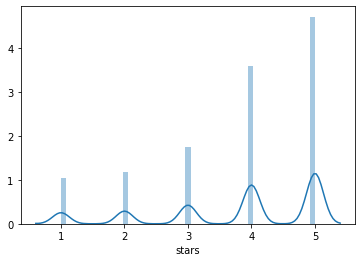

In [27]:
''' Visualizing the distribution of Ratings '''
sns.distplot(reviews_df['stars'])

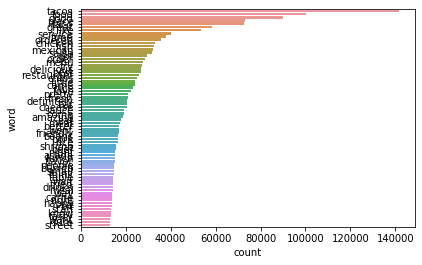

In [28]:
''' Visualizing the most used diction in the data  '''

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')
    
    
wc = count(reviews_df['tokens'])

sns.barplot(x='count', y='word', data = (wc[wc['count'] > 13000]))
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 13

In [29]:
vect = TfidfVectorizer(stop_words='english')
scaler = StandardScaler(with_mean=False, with_std=False)
sgdc = SGDRegressor(alpha=0.0001, 
                    average=False, 
                    early_stopping=False,
                    epsilon=0.1,
                    eta0=0.01, 
                    fit_intercept=True, 
                    l1_ratio=0.15,
                    learning_rate='adaptive', 
                    loss='squared_loss', 
                    max_iter=1000,
                    n_iter_no_change=42, 
                    penalty='l2', 
                    power_t=0.25, 
                    random_state=69,
                    shuffle=True, 
                    tol=0.001, 
                    validation_fraction=0.1, 
                    verbose=0,
                    warm_start=False)

pipe = Pipeline([('vect', vect), 
                 ('scaler', scaler),
                 ('clf', sgdc)])
# Fit Pipeline
pipe.fit(reviews_df['tokens'].astype(str), reviews_df['stars'])

# Declaring some parameters to fine tune
parameters = {
    #'clf__alpha' : (.0001),
    #'clf__max_iter' : (1000),
    'clf__n_iter_no_change' : (45, 50),
    #'clf__learning_rate' : ('constant', 'optimal', 'invscaling', 'adaptive'),
    #'clf__tol' : (.001, .002, .01, .1),
    #'clf__loss' : ('squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'),
    #'clf__penalty' : ('none', 'l2', 'l1', 'elasticnet')
    

}

# Instantiating grid Search
grid_search = GridSearchCV(pipe,parameters, cv=5, n_jobs=-1, verbose=1)

# Fitting to find the.... best fits
grid_search.fit(reviews_df['tokens'].astype(str), reviews_df['stars'])

# Printing out the best params along with the best accuracy score via grid search
print(grid_search.best_params_, grid_search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   43.8s remaining:   29.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.0min finished


{'clf__n_iter_no_change': 50} 0.644226867642398


In [30]:
y_pred = grid_search.predict(tacos_df['tokens'].astype(str))

In [31]:
''' Sampling to be sure it worked '''
print(y_pred[420])
tacos_df['text'].iloc[420]

3.799389986360605


'I liked the food here, not a busy place. I ordered a beef burrito, 2 pulled pork hard tacos and a chicken quesadilla. I had ordered the beef in the past and wanted to try something different - preferred the beef to the chicken for sure. The tacos were surprisingly good - I was used to eating tacos at a mexican place in downtown Portchester NY - this reminded me of those days. The pork was very nice and tender. The burrito on the other hand had too much filling - I could not finish all of it. Will be going back.'

In [32]:
tacos_df['modified_rating'] = y_pred
spare = tacos_df

In [33]:
tacos_df = spare

In [34]:
print(tacos_df.shape)
tacos_df.head()

(121979, 8)


,user_id,business_id,stars,text,name,rating,tokens,modified_rating
88,i1XAHltBpZC5zP5skcwVGw,VR6GpWIda3SfvPC-lg9H3w,4,A local friend introduced me to this jewel res...,"""Tuck Shop""",4.5,"[local, friend, introduced, jewel, restaurant,...",4.523351
94,kzXh1wIcCekofvPH5PGBgw,VR6GpWIda3SfvPC-lg9H3w,4,I've been coming here for a couple of years no...,"""Tuck Shop""",4.5,"[coming, couple, years, disappointed, service,...",4.435206
102,zzgb9L3NBT9V8BGw_DcVYw,VR6GpWIda3SfvPC-lg9H3w,5,Getting an RSVP at one of Montreal's best rest...,"""Tuck Shop""",4.5,"[getting, rsvp, montreal, best, restaurants, d...",4.739487
108,D8nma4ZaqHmSc8uLDbyBdw,VR6GpWIda3SfvPC-lg9H3w,5,"Our first time at Tuck Shop, what a place what...","""Tuck Shop""",4.5,"[time, tuck, shop, place, service, zucchini, b...",4.607139
127,93vyTaJgzQRQO4Zs9Cg_pw,VR6GpWIda3SfvPC-lg9H3w,5,I'm not sure if you use the word tuck-shop in ...,"""Tuck Shop""",4.5,"[sure, use, word, tuck, shop, canada, means, r...",4.112799


In [35]:
''' Renaming the columns to prepare for export '''
tacos_df = tacos_df.rename(columns = {'text' : 'original_text_review', 
                                      'stars' : 'original_yelp_user_rating', 
                                      'rating' : 'yelp_store_rating',
                                      'name' : 'business_name',
                                      'modified_rating': 'adjusted_sentiment_rating',
                                      'tokens' : 'tokenized_review'})

In [36]:
''' Reordering Columns to more succinct format '''
tacos_df = tacos_df[['business_id', 'business_name', 'yelp_store_rating', 
                     'user_id', 'original_yelp_user_rating', 
                     'adjusted_sentiment_rating', 'original_text_review', 
                     'tokenized_review']]

In [37]:
''' Removing outliers Greater than 5 '''
mask = (tacos_df['adjusted_sentiment_rating'] < 5)
tacos_df = tacos_df[mask]

In [38]:
''' Removing the outliers Less than 0 '''
mask = (tacos_df['adjusted_sentiment_rating'] > 0)
tacos_df = tacos_df[mask]

In [39]:
tacos_df.shape

(114253, 8)

In [40]:
tacos_df.head()

,business_id,business_name,yelp_store_rating,user_id,original_yelp_user_rating,adjusted_sentiment_rating,original_text_review,tokenized_review
88,VR6GpWIda3SfvPC-lg9H3w,"""Tuck Shop""",4.5,i1XAHltBpZC5zP5skcwVGw,4,4.523351,A local friend introduced me to this jewel res...,"[local, friend, introduced, jewel, restaurant,..."
94,VR6GpWIda3SfvPC-lg9H3w,"""Tuck Shop""",4.5,kzXh1wIcCekofvPH5PGBgw,4,4.435206,I've been coming here for a couple of years no...,"[coming, couple, years, disappointed, service,..."
102,VR6GpWIda3SfvPC-lg9H3w,"""Tuck Shop""",4.5,zzgb9L3NBT9V8BGw_DcVYw,5,4.739487,Getting an RSVP at one of Montreal's best rest...,"[getting, rsvp, montreal, best, restaurants, d..."
108,VR6GpWIda3SfvPC-lg9H3w,"""Tuck Shop""",4.5,D8nma4ZaqHmSc8uLDbyBdw,5,4.607139,"Our first time at Tuck Shop, what a place what...","[time, tuck, shop, place, service, zucchini, b..."
127,VR6GpWIda3SfvPC-lg9H3w,"""Tuck Shop""",4.5,93vyTaJgzQRQO4Zs9Cg_pw,5,4.112799,I'm not sure if you use the word tuck-shop in ...,"[sure, use, word, tuck, shop, canada, means, r..."


In [41]:
''' Getting the adjusted store reviews '''
a = tacos_df.groupby('business_id')['adjusted_sentiment_rating'].mean()

In [42]:
b = pd.DataFrame(a)

In [43]:
b = b.rename(columns = {'adjusted_sentiment_rating' : 'adjusted_store_rating'}) 
print(b.shape)
b.head()

(10563, 1)


,adjusted_store_rating
business_id,
--FBCX-N37CMYDfs790Bnw,4.535591
--GM_ORV2cYS-h38DSaCLw,3.899200
--cZ6Hhc9F7VkKXxHMVZSQ,4.414962
-01XupAWZEXbdNbxNg5mEg,3.537123
-092wE7j5HZOogMLAh40zA,3.163127


In [44]:
''' Merging the new dataframe on '''
c = pd.merge(b, tacos_df, how='outer', left_index=True, right_on='business_id')

In [45]:
c

,adjusted_store_rating,business_id,business_name,yelp_store_rating,user_id,original_yelp_user_rating,adjusted_sentiment_rating,original_text_review,tokenized_review
3784439,4.535591,--FBCX-N37CMYDfs790Bnw,"""The Bar At Bermuda & St. Rose""",3.5,-FcEjpQyBbE7b0BU19lErQ,5,4.535591,We've been coming here for years. The staff is...,"[coming, years, staff, great, recently, added,..."
4737409,3.899200,--GM_ORV2cYS-h38DSaCLw,"""Mm Mm Pizza""",4.0,ZjHDoLXzLcj023N1a7WTww,4,3.899200,Ordered several pizzas for a work party..chees...,"[ordered, pizzas, work, party, cheeseburger, b..."
907246,4.414962,--cZ6Hhc9F7VkKXxHMVZSQ,"""Pio Pio""",4.0,haEqV41MSa3d4KFuMia76w,4,3.956057,I was busy cooking dinner when my friend calle...,"[busy, cooking, dinner, friend, called, said, ..."
907424,4.414962,--cZ6Hhc9F7VkKXxHMVZSQ,"""Pio Pio""",4.0,MvblGTq2F6CiWd83mccnPA,4,4.873866,"Great food. Chicken, rice and beans, tacos, pl...","[great, food, chicken, rice, beans, tacos, pla..."
1938376,3.537123,-01XupAWZEXbdNbxNg5mEg,"""18 Degrees Neighborhood Grill""",3.0,-CVmjsibfqwcOdNRQtaRLA,3,3.537123,Went here last week with the husband for dinne...,"[went, week, husband, dinner, coupon, saw, fri..."
...,...,...,...,...,...,...,...,...,...
1796425,3.733265,zzwicjPC9g246MK2M1ZFBA,"""Sizzler""",3.0,w0B7U_-vU2y7O2rpzR2nbA,3,4.097813,"CHEESE TOAST *drops mic, walks away*\n\nI grew...","[cheese, toast, drops, mic, walks, away, grew,..."
1796426,3.733265,zzwicjPC9g246MK2M1ZFBA,"""Sizzler""",3.0,DK57YibC5ShBmqQl97CKog,3,2.801825,"Wow, what a blast from the past! I hadn't eat...","[wow, blast, past, hadn, eaten, sizzler, popul..."
1796427,3.733265,zzwicjPC9g246MK2M1ZFBA,"""Sizzler""",3.0,xnN53sx27hyIYmSzUwCwHg,4,4.399360,Great alternative to the now defunct Sweet Tom...,"[great, alternative, defunct, sweet, tomatoes,..."
1796428,3.733265,zzwicjPC9g246MK2M1ZFBA,"""Sizzler""",3.0,YTtaAnHMsXozVB29qr3sbA,3,3.429378,I haven't been to a Sizzler in a long time. Th...,"[haven, sizzler, long, time, review, salad, ba..."


In [46]:
tacos_df = c

In [47]:
''' Reordering Columns to more succinct format '''
tacos_df = tacos_df[['business_id', 'business_name', 'yelp_store_rating', 
                     'adjusted_store_rating', 
                     'user_id', 'original_yelp_user_rating', 
                     'adjusted_sentiment_rating', 'original_text_review', 
                     'tokenized_review']]

In [48]:
tacos_df.head(50)

,business_id,business_name,yelp_store_rating,adjusted_store_rating,user_id,original_yelp_user_rating,adjusted_sentiment_rating,original_text_review,tokenized_review
3784439,--FBCX-N37CMYDfs790Bnw,"""The Bar At Bermuda & St. Rose""",3.5,4.535591,-FcEjpQyBbE7b0BU19lErQ,5,4.535591,We've been coming here for years. The staff is...,"[coming, years, staff, great, recently, added,..."
4737409,--GM_ORV2cYS-h38DSaCLw,"""Mm Mm Pizza""",4.0,3.899200,ZjHDoLXzLcj023N1a7WTww,4,3.899200,Ordered several pizzas for a work party..chees...,"[ordered, pizzas, work, party, cheeseburger, b..."
907246,--cZ6Hhc9F7VkKXxHMVZSQ,"""Pio Pio""",4.0,4.414962,haEqV41MSa3d4KFuMia76w,4,3.956057,I was busy cooking dinner when my friend calle...,"[busy, cooking, dinner, friend, called, said, ..."
907424,--cZ6Hhc9F7VkKXxHMVZSQ,"""Pio Pio""",4.0,4.414962,MvblGTq2F6CiWd83mccnPA,4,4.873866,"Great food. Chicken, rice and beans, tacos, pl...","[great, food, chicken, rice, beans, tacos, pla..."
1938376,-01XupAWZEXbdNbxNg5mEg,"""18 Degrees Neighborhood Grill""",3.0,3.537123,-CVmjsibfqwcOdNRQtaRLA,3,3.537123,Went here last week with the husband for dinne...,"[went, week, husband, dinner, coupon, saw, fri..."
3830183,-092wE7j5HZOogMLAh40zA,"""Wong's Jr""",3.5,3.163127,IC7NLIeWhS45_aEE_8aVUg,4,3.163127,This place is my favorite Chinese food place w...,"[place, favorite, chinese, food, place, miles,..."
3889700,-0t6o9LXMVQ3aV8CHhRTnA,"""AZ International Marketplace""",3.5,4.497676,oUst55rUuv2nKEQ0FgJ5GQ,4,4.497676,Wow ... what a huge market indeed. This is the...,"[wow, huge, market, sister, store, smaller, me..."
1668176,-0tgMGl7D9B10YjSN2ujLA,"""Dubliner""",3.5,4.221543,tfBnJCPMpI989z6N5vPPug,5,4.221543,Shepards pie and taco Tuesday are definitely j...,"[shepards, pie, taco, tuesday, definitely, cou..."
2496748,-1VaIJza42Hjev6ukacCNg,"""Rio Mirage Cafe Y Cantina""",4.0,3.841703,SUMR4k6sqSFFrBpMKq0HWg,3,3.971430,"The food is great, shrimp cocktails have an au...","[food, great, shrimp, cocktails, authentic, fl..."
2496757,-1VaIJza42Hjev6ukacCNg,"""Rio Mirage Cafe Y Cantina""",4.0,3.841703,vRhszJeS0GMLvMDT8eC3OQ,4,3.690165,We took a break from the Christmas shopping cr...,"[took, break, christmas, shopping, craziness, ..."


In [49]:
tacos_df.iloc[420]

business_id                                             -6tvduBzjLI1ISfs3F_qTg
business_name                                             "Joyride Taco House"
yelp_store_rating                                                            4
adjusted_store_rating                                                  3.80471
user_id                                                 yJaqAq9oVLHrzY_ZHUZyYw
original_yelp_user_rating                                                    4
adjusted_sentiment_rating                                              4.45047
original_text_review         Love that Gilbert AZ is coming up in the world...
tokenized_review             [love, gilbert, coming, world, moved, chandler...
Name: 673532, dtype: object

In [50]:
''' Create a local JSON file that we can send to Backend '''
#tacos_df.to_json('adjusted_reviews.json', orient='records', lines=True)

' Create a local JSON file that we can send to Backend '

In [51]:
min(tacos_df['adjusted_sentiment_rating'])

0.008528909341936064

In [52]:
max(tacos_df['adjusted_sentiment_rating'])

4.999826596171201

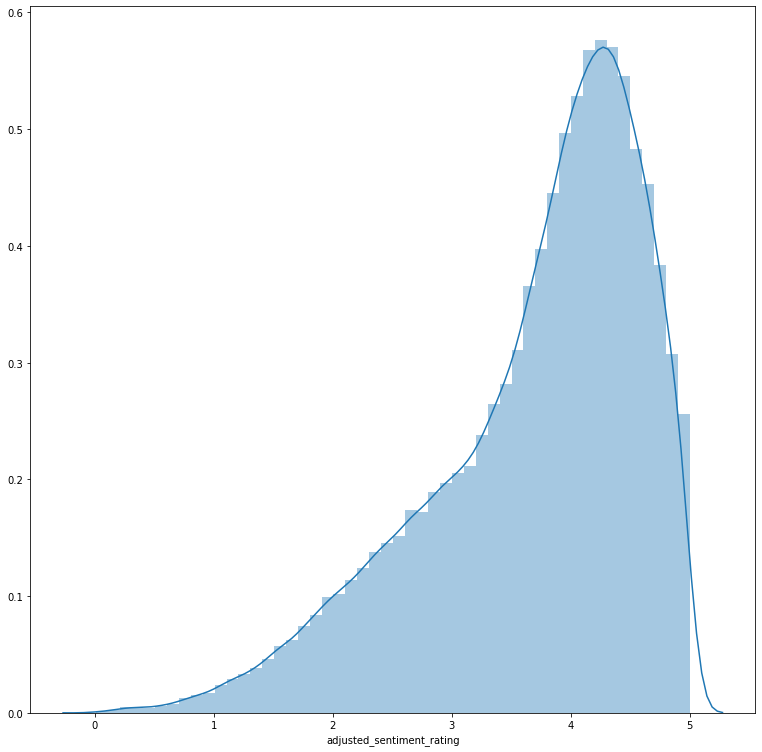

In [53]:
''' The distribution of the adjusted sentiment ratings w/ outliers removed '''
sns.distplot(tacos_df['adjusted_sentiment_rating'])

In [54]:
y_pred

array([4.52335091, 4.43520618, 4.73948655, ..., 3.98861992, 2.20334671,
       3.47796396])

In [55]:
grid_search.predict(fake_ass_review)

array([4.55734712])

In [56]:
grid_search.predict(['''
Fuck this place. Awful. Horrible. Beautiful.
'''])

array([1.03043175])

In [57]:
''' 
From here, make a new dataframe that includes the old AND new stars, and then can run 
an XGB regressor on all the extra data(the text data and sentiment is summed up with the
modified sentiemtn rating) Then the final regressor rating will be... THE THING 
'''

' \nFrom here, make a new dataframe that includes the old AND new stars, and then can run \nan XGB regressor on all the extra data(the text data and sentiment is summed up with the\nmodified sentiemtn rating) Then the final regressor rating will be... THE THING \n'

In [58]:
X_train = reviews_df['tokens']
y_train = np.array(reviews_df['stars'])
x_test = X_test

In [59]:
y_train

array([5, 3, 2, ..., 4, 5, 4])

In [60]:
reviews_df['tokens'].shape

(112220,)

In [61]:
tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(reviews_df['tokens'])

sequences = tokenizer.texts_to_sequences(reviews_df['tokens'])
data = pad_sequences(sequences, maxlen=100)

In [62]:
tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(x_test['tokens'])

sequences = tokenizer.texts_to_sequences(x_test['tokens'])
x_test = pad_sequences(sequences, maxlen=100)

In [63]:
print(data.shape)

(112220, 100)


In [64]:
x_test.shape

(9759, 100)

In [65]:
data

array([[    0,     0,     0, ...,     7,    18,    29],
       [    0,     0,     0, ...,     4,   240,   623],
       [    0,     0,  1642, ...,     4,    61,    78],
       ...,
       [    0,     0,     0, ..., 10520,  1832,  2375],
       [    0,     0,     0, ...,  5817,     6,   570],
       [    0,     0,     0, ...,     7,   488,   431]], dtype=int32)

In [66]:
print(y_train.T.shape)
y_train.T 

(112220,)


array([5, 3, 2, ..., 4, 5, 4])

In [67]:
y_train

array([5, 3, 2, ..., 4, 5, 4])

In [68]:
def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [69]:
y_train = encode(y_train)

Shape of data (BEFORE encode): (112220,)
Shape of data (AFTER  encode): (112220, 6)



In [70]:
y_train

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [71]:
model = Sequential()
model.add(Embedding(20000, 100))
model.add(LSTM(100, dropout=.2, recurrent_dropout=.2))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 6)                 606       
Total params: 2,081,006
Trainable params: 2,081,006
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.predict(x_test)

array([[0.16888948, 0.16481489, 0.16881853, 0.16362381, 0.1688071 ,
        0.16504619],
       [0.16886649, 0.16435526, 0.1632299 , 0.16709252, 0.17048118,
        0.16597469],
       [0.16652665, 0.16938056, 0.16510127, 0.16529417, 0.16734068,
        0.16635662],
       ...,
       [0.16794325, 0.1635451 , 0.1667635 , 0.16767468, 0.1683858 ,
        0.16568775],
       [0.16654298, 0.16803387, 0.16519336, 0.16804181, 0.1669511 ,
        0.16523688],
       [0.16704193, 0.16889085, 0.1663398 , 0.16385254, 0.16667663,
        0.1671983 ]], dtype=float32)

In [73]:
X_test.iloc[0]

user_id                                   g4ptSwb0C1b7PYDo8lHDpQ
business_id                               bMSiHjs2fbKbBNPyuTwhHA
stars                                                          4
text           I'm gonna say four stars because the current o...
name                                              "Coastal Taco"
rating                                                       2.5
tokens         [gonna, stars, current, overall, warranted, pr...
Name: 2390802, dtype: object

In [74]:
model_conv = Sequential()
model_conv.add(Embedding(20000, 200))
model_conv.add(Dropout(0.2)) 
model_conv.add(Conv1D(128, 6, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(200))
model_conv.add(Dense(6, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [75]:
model_conv.fit(data, y_train,  validation_split=.085, epochs=10, batch_size=2048)

Train on 102681 samples, validate on 9539 samples
Epoch 1/10
102681/102681 [==============================] - 130s 1ms/sample - loss: 1.3028 - accuracy: 0.4339 - val_loss: 0.9864 - val_accuracy: 0.5618
Epoch 2/10
102681/102681 [==============================] - 125s 1ms/sample - loss: 0.9045 - accuracy: 0.5983 - val_loss: 0.9030 - val_accuracy: 0.6015
Epoch 3/10
102681/102681 [==============================] - 124s 1ms/sample - loss: 0.8280 - accuracy: 0.6372 - val_loss: 0.9293 - val_accuracy: 0.5865
Epoch 4/10
102681/102681 [==============================] - 127s 1ms/sample - loss: 0.7912 - accuracy: 0.6551 - val_loss: 0.9140 - val_accuracy: 0.5945
Epoch 5/10
102681/102681 [==============================] - 128s 1ms/sample - loss: 0.7603 - accuracy: 0.6714 - val_loss: 0.9312 - val_accuracy: 0.5984
Epoch 6/10
102681/102681 [==============================] - 128s 1ms/sample - loss: 0.7254 - accuracy: 0.6911 - val_loss: 0.9694 - val_accuracy: 0.5917
Epoch 7/10
102681/102681 [============

In [76]:
a = model_conv.predict(x_test)

In [77]:
a[9758]

array([0.00242021, 0.01453706, 0.03021179, 0.11634187, 0.28991994,
       0.5465691 ], dtype=float32)

In [78]:
x_test.shape

(9759, 100)

In [79]:
from joblib import dump
dump(pipe, 'pipeline.joblib')

['pipeline.joblib']